#### Важное требование ко всей домашке в целом: в jupyter ноутбуке не должно был лишнего кода (т.е. если вы взяли за основу семинар, не забудьте удалить все лишнее)

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window используется не так и вам нужно это  изменить!)  

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [38]:
# %pip install tensorflow

In [39]:
# Импорты
# !pip3 install tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from tqdm import tqdm
import re

# !pip3 install pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [5]:
data = open(r'wiki_data.txt', encoding='utf-8').read().split('\n')

In [6]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    # лемматизация
    lemmas = [morph.parse(word)[0].normal_form for word in tokens]
    return lemmas

In [7]:
vocab = Counter()

for text in tqdm(data):
    vocab.update(preprocess(text))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

100%|████████████████████████████████████████████████████████████████████████████| 20003/20003 [20:29<00:00, 16.27it/s]


In [23]:
# import pickle
# f = open(r'file.txt', 'wb')
# pickle.dump(vocab, f)
# f.close()

In [9]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [10]:
sentences = []

for text in tqdm(data):
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

100%|████████████████████████████████████████████████████████████████████████████| 20003/20003 [19:11<00:00, 17.38it/s]


In [11]:
vocab_size = len(id2word)

In [16]:
# skip gram
def gen_batches_sg(sentences, window, batch_size=512):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window//2):i] + sent[i+1:i+window//2]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []


In [13]:
# skip-gram

inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
model.fit(gen_batches_sg(sentences[:19000], window=12),
          validation_data=gen_batches_sg(sentences[19000:],  window=12),
          batch_size=512,
          steps_per_epoch=3000,
          validation_steps=30,
         epochs=3)

Epoch 1/3
3000/3000 [==============================] - 381s 127ms/step - loss: 0.3770 - accuracy: 0.8312 - val_loss: 0.5438 - val_accuracy: 0.7808
Epoch 2/3
3000/3000 [==============================] - 365s 122ms/step - loss: 0.3724 - accuracy: 0.8335 - val_loss: 0.5696 - val_accuracy: 0.7677
Epoch 3/3
3000/3000 [==============================] - 368s 123ms/step - loss: 0.3834 - accuracy: 0.8304 - val_loss: 0.4201 - val_accuracy: 0.8295


In [18]:
embeddings1 = model.layers[2].get_weights()[0]

In [19]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [24]:
most_similar('тайна', embeddings1)

['тайна',
 'эмоция',
 'будто',
 'маг',
 'различаться',
 'приобретать',
 'земледелие',
 'коллега',
 'тенденция',
 'видеть']

In [21]:
most_similar('студент', embeddings1)

['студент',
 'курс',
 'политехнический',
 'учиться',
 'иностранный',
 'ученик',
 'окончить',
 'математика',
 'преподавать',
 'профессор']

In [28]:
most_similar('город', embeddings1)

['город',
 'столица',
 'празднование',
 'провинция',
 'набережная',
 'военнослужащий',
 'территория',
 'участок',
 'старое',
 'разрушить']

В целом, модель выдает неплохие результаты - для "студента" все ближайшие слова действительно близки по смыслу/контексту, для "города" и "тайны" чуть хуже.

In [36]:
# # cbow 
def gen_batches_cbow(sentences, window = 6, batch_size=512):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window//2):i] + sent[i+1:i+window//2]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [37]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [38]:
model.fit(gen_batches_cbow(sentences[:19000], window=6),
          validation_data=gen_batches_cbow(sentences[19000:],  window=6),
          batch_size=512,
          steps_per_epoch=3000,
          validation_steps=30,
         epochs=3)

Epoch 1/3
3000/3000 [==============================] - 393s 130ms/step - loss: 0.4015 - accuracy: 0.8230 - val_loss: 0.4306 - val_accuracy: 0.8335
Epoch 2/3
3000/3000 [==============================] - 402s 134ms/step - loss: 0.3330 - accuracy: 0.8612 - val_loss: 0.3483 - val_accuracy: 0.8713
Epoch 3/3
3000/3000 [==============================] - 381s 127ms/step - loss: 0.2938 - accuracy: 0.8799 - val_loss: 0.3423 - val_accuracy: 0.8693


In [39]:
embeddings2 = model.layers[2].get_weights()[0]

In [40]:
most_similar('тайна', embeddings2)

['тайна',
 'мистический',
 'мистер',
 '«от',
 'загадочный',
 'тим',
 'детектив',
 'вампир',
 'миссис',
 'идол']

In [41]:
most_similar('студент', embeddings2)

['студент',
 'факультет',
 'медицинский',
 'университет',
 'вуз',
 'преподаватель',
 'университетский',
 'выпускник',
 'ректор',
 'обучение']

In [42]:
most_similar('город', embeddings2)

['город', 'и', 'в', 'который', 'он', 'на', 'быть', 'год', 'по', 'из']

В целом и cbow, и skipgram выдают похожие слова - интересно, что для "студента" они стабильно отличные (пробовала считать для семинарской "церкви" - для нее тоже выдает похожее на то, что было в семинаре), а вот некоторые более бытовые слова показывают результаты хуже - скорее всего, связано со спецификой корпуса.

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [40]:
# !pip install gensim
import gensim

In [45]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [49]:
wiki = open(r'wiki_data.txt', encoding='utf-8').read().split('\n')
texts = [preprocess(text) for text in wiki]

In [50]:
from gensim.models import Word2Vec

In [52]:
# Word2Vec

# Почему-то colab считает vector_size не принадлежащим __init__ в word2vec - 
# зато устаревший size принимает, хотя, по идее, должно быть наоброт. В jupyter все хорошо.
w2v = gensim.models.Word2Vec(texts, 
                             vector_size=100, 
                             min_count=10, 
                             max_vocab_size=12000,
                             window=7,
                             epochs=10,
                             sg=0,
                             hs=1, 
                             sample=1e-4,
                             ns_exponent=0.92, 
                             cbow_mean=0)

In [56]:
w2v.wv.most_similar('город')

[('провинции', 0.7833091616630554),
 ('центр', 0.7729331254959106),
 ('города', 0.7619381546974182),
 ('коммуны', 0.7433444857597351),
 ('округ', 0.7151840329170227),
 ('расположен', 0.6984953284263611),
 ('и', 0.6976277232170105),
 ('в', 0.6948266625404358),
 ('уезд', 0.6899014115333557),
 ('а', 0.6891608238220215)]

In [57]:
# FastText
ft = gensim.models.FastText(texts, min_n=2, max_n=7)

In [58]:
ft.wv.most_similar("контейнер")

[('конвейер', 0.9040170907974243),
 ('контур', 0.8901160359382629),
 ('контроллер', 0.8791548609733582),
 ('контент', 0.8753628730773926),
 ('контингент', 0.867443859577179),
 ('кондиционер', 0.8651267886161804),
 ('коннор', 0.8608549237251282),
 ('корриентес', 0.8562175631523132),
 ('контрерас', 0.8540083765983582),
 ('кондор', 0.8489197492599487)]

In [59]:
ft.wv.most_similar("тайна")

[('тайфуна', 0.9661746621131897),
 ('тайсона', 0.9281504154205322),
 ('тумана', 0.9098391532897949),
 ('таксона', 0.8943200707435608),
 ('титана', 0.8880762457847595),
 ('тайма', 0.8845145106315613),
 ('тина', 0.8799522519111633),
 ('тона', 0.873836100101471),
 ('торна', 0.8729273676872253),
 ('тонна', 0.8717372417449951)]

In [60]:
ft.wv.most_similar("студент")

[('студенец', 0.8681114912033081),
 ('стипендиат', 0.8448348045349121),
 ('спецагент', 0.823511004447937),
 ('аттестат', 0.8127027750015259),
 ('манифест', 0.7976201176643372),
 ('дентат', 0.7910749912261963),
 ('студенок', 0.7907235622406006),
 ('претендент', 0.7829762697219849),
 ('акцент', 0.7798030376434326),
 ('суккулент', 0.7777469754219055)]

Модель fast text выдала просто внешне похожие слова, а модель word2vec и правда похожие по смыслу - видно, что в fasttext используются символьные n-граммы. С такими параметрами модель word2vec выдает результаты лучше.

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [30]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    # лемматизация
    lemmas = [morph.parse(word)[0].normal_form for word in tokens]
    return lemmas

In [4]:
data = pd.read_csv('labeled.csv')
data['norm_text'] = data.comment.apply(preprocess)

In [31]:
data.head()

,comment,toxic,norm_text,extra
0,"Верблюдов-то за что? Дебилы, бл...\r\n",1.0,"[верблюд-то, за, что, дебил, бл]","[верблюд_NOUN, то_PART, за_ADP, что_PRON, деби..."
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол, это, отдушина, затюканый, россиянин, м...","[хохол_NOUN, это_PART, отдушина_NOUN, затюканы..."
2,Собаке - собачья смерть\r\n,1.0,"[собака, , собачий, смерть]","[собака_NOUN, собачий_ADJ, смерть_NOUN]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница, обновить, дебил, это, тоже, не, оск...","[страница_NOUN, обновлять_VERB, дебил_NOUN, эт..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты, не, убедить, 6-страничный, пдф, в, тот, ч...","[ты_PRON, не_PART, убеждать_VERB, страничный_A..."


In [32]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6309

In [33]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [34]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [205]:
len(X)

14412

In [35]:
# FastText Classifier
X_ft = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y_ft = data.toxic.values

X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X_ft, y_ft, test_size=0.1)

weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    if word == 'PAD':
        continue

    try:
        weights[i] = ft.wv[word]
    
    except KeyError:
        continue
        weights[i] = ft.wv['втжлыою']
        
inputs = tf.keras.layers.Input(shape=(100,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

ft_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
ft_classifier.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  

ft_classifier.fit(X_train_ft, y_train_ft, 
          validation_data=(X_test_ft, y_test_ft),
          batch_size=32,
         epochs=30)

NameError: name 'ft' is not defined

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


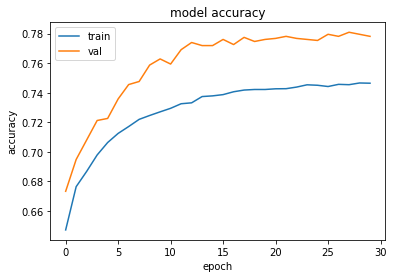

In [119]:
print(ft_classifier.history.history.keys())

acc1= ft_classifier.history.history['accuracy'][-1]
plt.plot(ft_classifier.history.history['accuracy'])
plt.plot(ft_classifier.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [166]:
# Word2vec Classifier
X_w2 = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y_w2 = data.toxic.values

X_train_w2, X_test_w2, y_train_w2, y_test_w2 = train_test_split(X_w2, y_w2, test_size=0.1)

weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    if word == 'PAD':
        continue

    try:
        weights[i] = w2v.wv[word]
    
    except KeyError:
        continue
        weights[i] = w2v.wv['втжлыою']
        
inputs = tf.keras.layers.Input(shape=(100,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

w2v_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
w2v_classifier.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  

w2v_classifier.fit(X_train_w2, y_train_w2, 
          validation_data=(X_test_w2, y_test_w2),
          batch_size=32,
         epochs=30)

Epoch 1/30
406/406 [==============================] - 2s 3ms/step - loss: 0.6426 - accuracy: 0.6636 - val_loss: 0.6177 - val_accuracy: 0.6789
Epoch 2/30
406/406 [==============================] - 1s 2ms/step - loss: 0.6173 - accuracy: 0.6636 - val_loss: 0.6119 - val_accuracy: 0.6789
Epoch 3/30
406/406 [==============================] - 1s 2ms/step - loss: 0.6153 - accuracy: 0.6636 - val_loss: 0.6114 - val_accuracy: 0.6789
Epoch 4/30
406/406 [==============================] - 1s 2ms/step - loss: 0.6147 - accuracy: 0.6636 - val_loss: 0.6116 - val_accuracy: 0.6789
Epoch 5/30
406/406 [==============================] - 1s 2ms/step - loss: 0.6143 - accuracy: 0.6636 - val_loss: 0.6113 - val_accuracy: 0.6789
Epoch 6/30
406/406 [==============================] - 1s 2ms/step - loss: 0.6140 - accuracy: 0.6636 - val_loss: 0.6113 - val_accuracy: 0.6789
Epoch 7/30
406/406 [==============================] - 1s 2ms/step - loss: 0.6137 - accuracy: 0.6636 - val_loss: 0.6112 - val_accuracy: 0.6789
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


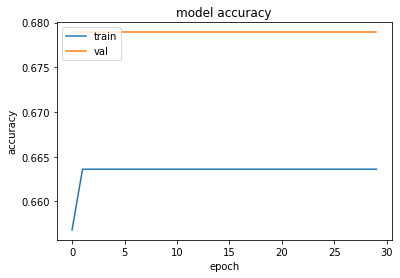

In [121]:
print(w2v_classifier.history.history.keys())
acc2=w2v_classifier.history.history['accuracy'][-1]
plt.plot(w2v_classifier.history.history['accuracy'])
plt.plot(w2v_classifier.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Для word2vec результаты выглядят подозрительно - кажется, модель не обучается( Loss остается практически одинаковым начиная со 2-й эпохи.

In [113]:
# cbow

X_cbow = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y_cbow = data.toxic.values

X_train_cbow, X_test_cbow, y_train_cbow, y_test_cbow = train_test_split(X_cbow, y_cbow, test_size=0.1)
weights = np.zeros((len(word2id), 300))

model_weights = embeddings1

for id in id2word.keys(): 
    if id == 0:
        continue
    try:
        weights[id] = model_weights[id]
      
      
    except KeyError:
        continue
        weights[id] = model_weights[100000000] 

inputs = tf.keras.layers.Input(shape=(300,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

cbow_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
cbow_classifier.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
cbow_classifier.fit(X_train_cbow, y_train_cbow, 
          validation_data=(X_test_cbow, y_test_cbow),
          batch_size=32,
          epochs=30)
  


Epoch 1/30
406/406 [==============================] - 4s 8ms/step - loss: 0.6613 - accuracy: 0.6641 - val_loss: 0.6410 - val_accuracy: 0.6623
Epoch 2/30
406/406 [==============================] - 3s 7ms/step - loss: 0.6332 - accuracy: 0.6655 - val_loss: 0.6303 - val_accuracy: 0.6623
Epoch 3/30
406/406 [==============================] - 3s 7ms/step - loss: 0.6277 - accuracy: 0.6655 - val_loss: 0.6286 - val_accuracy: 0.6623
Epoch 4/30
406/406 [==============================] - 3s 7ms/step - loss: 0.6265 - accuracy: 0.6655 - val_loss: 0.6280 - val_accuracy: 0.6623
Epoch 5/30
406/406 [==============================] - 3s 7ms/step - loss: 0.6259 - accuracy: 0.6655 - val_loss: 0.6276 - val_accuracy: 0.6623
Epoch 6/30
406/406 [==============================] - 3s 7ms/step - loss: 0.6254 - accuracy: 0.6655 - val_loss: 0.6273 - val_accuracy: 0.6623
Epoch 7/30
406/406 [==============================] - 3s 7ms/step - loss: 0.6249 - accuracy: 0.6655 - val_loss: 0.6269 - val_accuracy: 0.6623
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


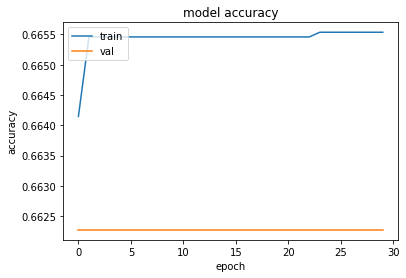

In [122]:
print(cbow_classifier.history.history.keys())
acc3=cbow_classifier.history.history['accuracy'][-1]
# summarize history for accuracy
plt.plot(cbow_classifier.history.history['accuracy'])
plt.plot(cbow_classifier.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [116]:
#skip-gram

X_skip = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y_skip = data.toxic.values

X_train_skip, X_valid_skip, y_train_skip, y_valid_skip = train_test_split(X_skip, y_skip, test_size=0.1)
weights = np.zeros((len(word2id), 300))

model_weights = embeddings2

for id in id2word.keys(): 
    if id == 0:
        continue
    try:
        weights[id] = model_weights[id]
      
      
    except KeyError:
        continue
        weights[id] = model_weights[100000000] 

inputs = tf.keras.layers.Input(shape=(300,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

skip_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
skip_classifier.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
skip_classifier.fit(X_train_skip, y_train_skip, 
          validation_data=(X_valid_skip, y_valid_skip),
          batch_size=32,
         epochs=30)
  


Epoch 1/30
406/406 [==============================] - 4s 8ms/step - loss: 0.6473 - accuracy: 0.6665 - val_loss: 0.6357 - val_accuracy: 0.6533
Epoch 2/30
406/406 [==============================] - 3s 8ms/step - loss: 0.6273 - accuracy: 0.6665 - val_loss: 0.6338 - val_accuracy: 0.6533
Epoch 3/30
406/406 [==============================] - 3s 8ms/step - loss: 0.6259 - accuracy: 0.6665 - val_loss: 0.6337 - val_accuracy: 0.6533
Epoch 4/30
406/406 [==============================] - 3s 8ms/step - loss: 0.6256 - accuracy: 0.6665 - val_loss: 0.6335 - val_accuracy: 0.6533
Epoch 5/30
406/406 [==============================] - 3s 8ms/step - loss: 0.6253 - accuracy: 0.6665 - val_loss: 0.6331 - val_accuracy: 0.6533
Epoch 6/30
406/406 [==============================] - 3s 8ms/step - loss: 0.6250 - accuracy: 0.6665 - val_loss: 0.6328 - val_accuracy: 0.6533
Epoch 7/30
406/406 [==============================] - 3s 8ms/step - loss: 0.6247 - accuracy: 0.6665 - val_loss: 0.6325 - val_accuracy: 0.6533
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


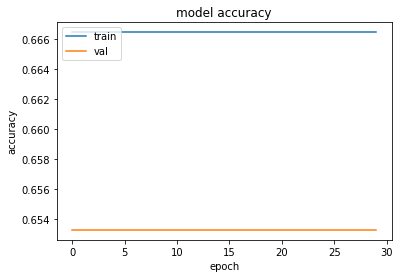

In [123]:
print(skip_classifier.history.history.keys())
acc4=skip_classifier.history.history['accuracy'][-1]
# summarize history for accuracy
plt.plot(skip_classifier.history.history['accuracy'])
plt.plot(skip_classifier.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [41]:
# metrics = pd.DataFrame({'Fasttext':acc1, 'Word2vec':acc2, "Cbow":acc3, "Skip-gram":acc4}, index=['Accuracy']).T

### RusVectores: ruwikiruscorpora-func_upos_skipgram_300_5_2019

In [8]:
rus_v_model = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [9]:
rus_v_model.most_similar('студент_NOUN')

[('семинарист_NOUN', 0.6852458715438843),
 ('гимназист_NOUN', 0.6708346605300903),
 ('аспирант_NOUN', 0.6496657133102417),
 ('студентка_NOUN', 0.6487054228782654),
 ('учащийся_NOUN', 0.6287897825241089),
 ('первокурсник_NOUN', 0.6265783309936523),
 ('ученик_NOUN', 0.6251557469367981),
 ('школьник_NOUN', 0.6132184267044067),
 ('абитуриент_NOUN', 0.6103333234786987),
 ('курсистка_NOUN', 0.596615731716156)]

In [10]:
mapping = {}

for line in open('./ru-rnc.map'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [11]:
from pymystem3 import Mystem
    
m = Mystem()

def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens

In [12]:
normalize_mystem('Привет')

['привет_NOUN']

In [42]:
# from tqdm._tqdm_notebook import tqdm_notebook
# import pandas as pd
# tqdm_notebook.pandas()

In [14]:
data['extra'] = data.comment.progress_apply(normalize_mystem)

  0%|          | 0/14412 [00:00<?, ?it/s]

In [15]:
#  data.to_csv('full_data.csv')

In [16]:
data.head()

,comment,toxic,norm_text,extra
0,"Верблюдов-то за что? Дебилы, бл...\r\n",1.0,"[верблюд-то, за, что, дебил, бл]","[верблюд_NOUN, то_PART, за_ADP, что_PRON, деби..."
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол, это, отдушина, затюканый, россиянин, м...","[хохол_NOUN, это_PART, отдушина_NOUN, затюканы..."
2,Собаке - собачья смерть\r\n,1.0,"[собака, , собачий, смерть]","[собака_NOUN, собачий_ADJ, смерть_NOUN]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница, обновить, дебил, это, тоже, не, оск...","[страница_NOUN, обновлять_VERB, дебил_NOUN, эт..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты, не, убедить, 6-страничный, пдф, в, тот, ч...","[ты_PRON, не_PART, убеждать_VERB, страничный_A..."


In [17]:
vocab = Counter()

for text in data['extra']:
    vocab.update(text)

In [18]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6216

In [19]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [21]:
X = []

for tokens in data['extra']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [22]:
len(X)

14412

In [203]:
len(data.toxic.values)

14412

In [27]:
# Pre-trained clf
X_ru = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y_ru = data.toxic.values

X_train_ru, X_test_ru, y_train_ru, y_test_ru = train_test_split(X_ru, y_ru, test_size=0.1)

weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():
    if word == 'PAD':
        continue

    try:
        weights[i] = rus_v_model[word]
    
    except KeyError:
        continue
        weights[i] = rus_v_model['втжлыою']
        
inputs = tf.keras.layers.Input(shape=(300,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                        trainable=False,
                                        weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

ru_classifier = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
ru_classifier.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  

ru_classifier.fit(X_train_ru, y_train_ru, 
          validation_data=(X_test_ru, y_test_ru),
          batch_size=32,
         epochs=30)

Epoch 1/30
406/406 [==============================] - 5s 11ms/step - loss: 0.6476 - accuracy: 0.6650 - val_loss: 0.6308 - val_accuracy: 0.6533
Epoch 2/30
406/406 [==============================] - 4s 10ms/step - loss: 0.6222 - accuracy: 0.6665 - val_loss: 0.6235 - val_accuracy: 0.6533
Epoch 3/30
406/406 [==============================] - 4s 10ms/step - loss: 0.6161 - accuracy: 0.6665 - val_loss: 0.6188 - val_accuracy: 0.6533
Epoch 4/30
406/406 [==============================] - 4s 9ms/step - loss: 0.6111 - accuracy: 0.6665 - val_loss: 0.6142 - val_accuracy: 0.6533
Epoch 5/30
406/406 [==============================] - 4s 9ms/step - loss: 0.6063 - accuracy: 0.6665 - val_loss: 0.6095 - val_accuracy: 0.6533
Epoch 6/30
406/406 [==============================] - 4s 10ms/step - loss: 0.6015 - accuracy: 0.6665 - val_loss: 0.6049 - val_accuracy: 0.6533
Epoch 7/30
406/406 [==============================] - 4s 9ms/step - loss: 0.5969 - accuracy: 0.6665 - val_loss: 0.6005 - val_accuracy: 0.6533
Ep

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


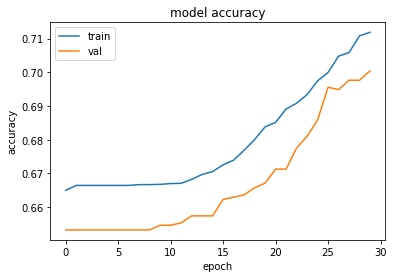

In [28]:
print(ru_classifier.history.history.keys())
acc5 = ru_classifier.history.history['accuracy'][-1]
# summarize history for accuracy
plt.plot(ru_classifier.history.history['accuracy'])
plt.plot(ru_classifier.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Итоги**

Самая высокая точность на последней эпохе у Fasttext - **0.73**, на втором месте модель rus vectores, обученная на корпусе из википедии (ruwikiruscorpora-func_upos_skipgram_300_5_2019) - **0.71**. Остальные модели показали accuracy ~ **0.65** - такая близость подозрительна, возможно, я где-то ошиблась

- Интересно, что, если смотреть вручную, самые похожие слова были у модели rus vectores, у fasttext же были в большинстве случаев похожи внешне, а не по смыслу. Но в машинных метриках это не отобразилось.